#### predicting medical charges based on various patient attributes using different machine learning models

packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
insurance_data = pd.read_csv("insurance.csv")

The insurance.csv file contains a sample of 1,338 individuals enrolled in the insurance plan, and the attributes represent the patient's characteristics and the total medical expenses charged to the plan for that year. The attributes include:

- age: An integer indicating the age of the primary patient (excluding those over 64, as these are typically covered by the government).
- sex: The policyholder's gender, male or female.
- bmi: Body mass index (BMI), which indicates how overweight or underweight a person is for their height. BMI is equal to weight (in kilograms) divided by height (in meters) squared. An ideal BMI is in the range of 18.5 to 24.9.
- children: An integer indicating the number of children/dependents covered by the insurance plan.
- smoker: A yes or no categorical variable indicating whether the insured smokes tobacco regularly.
- region: The beneficiary's place of residence in the U.S., divided into four geographic - regions: northeast, southeast, southwest, or northwest.
- charges: Medical billing
  
Let's take a look at our dataset

In [4]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Checking for missing values

In [6]:
insurance_data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There are no missing values but we want to see it visually. Our dependent variable is charges and independent variable is bmi.

In [8]:
data = insurance_data.loc[:,["bmi","charges"]]

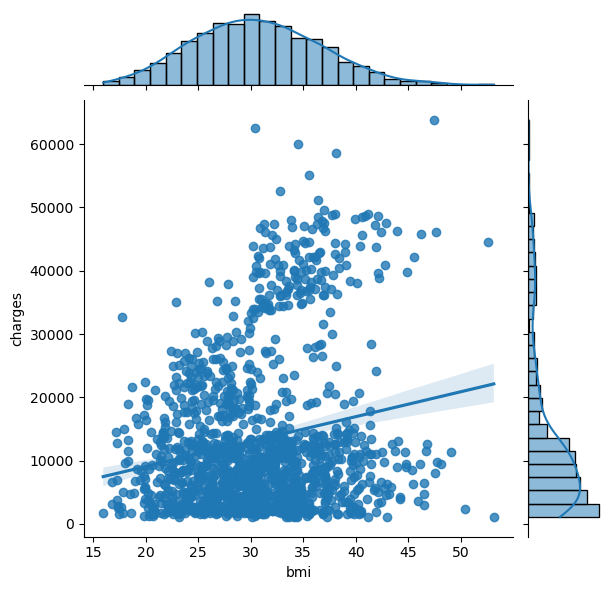

In [9]:
sb.jointplot(x = "bmi", y = "charges", data = data, kind="reg")

Let's see if there are outliers.

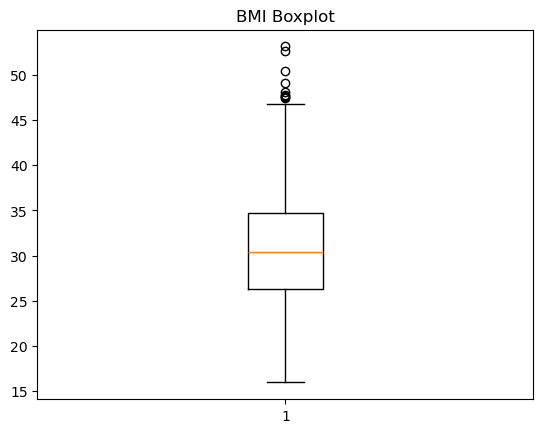

In [20]:
plt.boxplot(insurance_data['bmi'])
plt.title('BMI Boxplot')
plt.show()

to check where the outliers are

<Axes: >

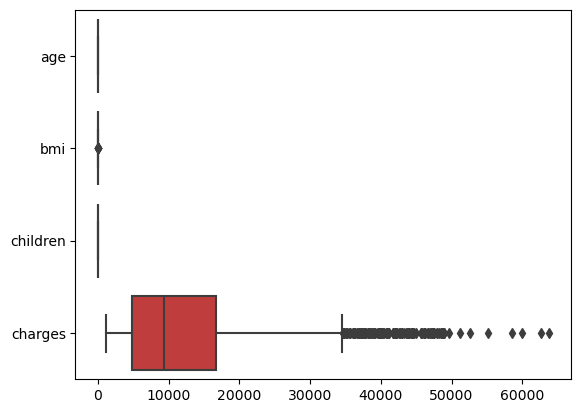

In [13]:
sb.boxplot(data = insurance_data, orient = 'h')

There are outliers in our dependent variable. We should determine a range that will identify outliers.

In [14]:
q1_y = insurance_data['charges'].quantile(0.25)
q3_y = insurance_data['charges'].quantile(0.75)

In [15]:
iqr_y = q3_y - q1_y

upper boundary and lower boundary:

In [16]:
lb_y = q1_y - 1.5 * iqr_y
ub_y = q3_y + 1.5 * iqr_y

Lower boundary can't be negative so we take it as zero. That's why when we try to find an outlier less than lower boundary the output will be zero.

In [28]:
outlier_low_y = (insurance_data['charges']< lb_y)

In [29]:
insurance_data['charges'][outlier_low_y].count()

0

Now let's find outliers bigger than the upper boundary

In [30]:
outlier_up_y = (insurance_data['charges']> ub_y)

In [31]:
insurance_data['charges'][outlier_up_y].count() 

139

There are 139 outliers

I am removing the outliers from my data set and reassign them to insurance_data.

In [35]:
insurance_data_withoutOutliers = insurance_data[ ~((insurance_data['charges'] < lb_y) | (insurance_data['charges'] > ub_y))]

In [36]:
insurance_data = insurance_data_withoutOutliers

Changing two binary independent variables as 1 and 2:

In [37]:
insurance_data.columns[insurance_data.nunique() == 2]

Index(['sex', 'smoker'], dtype='object')

In [42]:
binary_vars = ["sex", "smoker"]

In [43]:
def binary_map(x):
    return x.map({"yes":1,"no":2,"male":1,"female":2})

In [44]:
insurance_data[binary_vars] = insurance_data[binary_vars].apply(binary_map)

Let's check if they had changed

In [45]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,2,southeast,1725.55230
2,28,1,33.000,3,2,southeast,4449.46200
3,33,1,22.705,0,2,northwest,21984.47061
4,32,1,28.880,0,2,northwest,3866.85520


Yes! Now let's create a dummy variable for the region column.

In [46]:
insurance_data["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [47]:
status = pd.get_dummies(insurance_data["region"], drop_first=True)

In [48]:
insurance_data = pd.concat([insurance_data, status], axis = 1)

We don't need the region column now.

In [49]:
insurance_data.drop(["region"], axis = 1, inplace = True)

In [50]:
insurance_data.head(10)

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,2,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,2,1725.55230,False,True,False
2,28,1,33.000,3,2,4449.46200,False,True,False
3,33,1,22.705,0,2,21984.47061,True,False,False
4,32,1,28.880,0,2,3866.85520,True,False,False
5,31,2,25.740,0,2,3756.62160,False,True,False
6,46,2,33.440,1,2,8240.58960,False,True,False
7,37,2,27.740,3,2,7281.50560,True,False,False
8,37,1,29.830,2,2,6406.41070,False,False,False
9,60,2,25.840,0,2,28923.13692,True,False,False


We can split the dataset as train and test

In [51]:
insurance_data_train , insurance_data_test = train_test_split(insurance_data, train_size=0.7, test_size = 0.3, random_state=22)

Standardization:

In [53]:
scaler = MinMaxScaler()

In [55]:
numeric_vars = ["bmi","age","sex","children","smoker","charges"]

In [56]:
insurance_data_train[numeric_vars] = scaler.fit_transform(insurance_data_train[numeric_vars])

In [57]:
insurance_data_test[numeric_vars] = scaler.fit_transform(insurance_data_test[numeric_vars])

Here, we separate the features (independent variables) from the target variable (dependent variable, 'charges') for both the train and test sets.

In [59]:
insurance_data_y_train = insurance_data_train.pop("charges")

In [60]:
insurance_data_x_train = insurance_data_train

In [61]:
insurance_data_y_test = insurance_data_test.pop("charges")

In [62]:
insurance_data_x_test = insurance_data_test

#### Building a model for RFE

Linear regression model:

In [63]:
lm_RFE = LinearRegression()

Fitting our model

In [64]:
lm_RFE.fit(insurance_data_x_train,insurance_data_y_train)

LinearRegression()

Applying RFE with the fitted model.

In [65]:
rfe= RFE(lm_RFE,n_features_to_select=5)

In [66]:
rfe = rfe.fit(insurance_data_x_train,insurance_data_y_train)

In [67]:
list(zip(insurance_data_x_train.columns,rfe.support_,rfe.ranking_))

[('age', True, 1),
 ('sex', False, 4),
 ('bmi', True, 1),
 ('children', True, 1),
 ('smoker', True, 1),
 ('northwest', False, 3),
 ('southeast', False, 2),
 ('southwest', True, 1)]

Variables included in the model take the value 1.

In [69]:
y_pred_train = rfe.predict(insurance_data_x_train)

Predictions:

In [70]:
y_pred_train

array([0.33155799, 0.06598035, 0.29236471, 0.2997916 , 0.20503197,
       0.30657903, 0.20754239, 0.12301174, 0.28146892, 0.30064932,
       0.31327209, 0.0622116 , 0.36945025, 0.40586195, 0.13814156,
       0.19768092, 0.25272416, 0.37816841, 0.30001941, 0.10246916,
       0.35326039, 0.33379943, 0.06447009, 0.33583992, 0.39305051,
       0.04053786, 0.47886833, 0.26641734, 0.33169012, 0.31345151,
       0.10377261, 0.1162455 , 0.39320761, 0.27585183, 0.33213773,
       0.70708327, 0.14088133, 0.16362294, 0.60939118, 0.63573961,
       0.22337564, 0.11715234, 0.10597224, 0.33659212, 0.15030534,
       0.06220518, 0.12524191, 0.21642829, 0.12221539, 0.0458038 ,
       0.32059144, 0.06629102, 0.26177805, 0.36456662, 0.22995574,
       0.32086245, 0.15441309, 0.28741515, 0.23971043, 0.07253903,
       0.28145654, 0.05672006, 0.16445192, 0.37036353, 0.32060177,
       0.08353468, 0.08611602, 0.10530576, 0.57918872, 0.32605742,
       0.2183995 , 0.47313169, 0.27730581, 0.10270133, 0.69332

In [72]:
y_pred_test = rfe.predict(insurance_data_x_test)

In [73]:
y_pred_test

array([0.05443798, 0.0872724 , 0.22222473, 0.09450408, 0.2194661 ,
       0.31448516, 0.22460173, 0.24338858, 0.33696168, 0.0695371 ,
       0.26768101, 0.06003106, 0.33458758, 0.18537622, 0.30810316,
       0.55920088, 0.07277277, 0.03863138, 0.16676112, 0.32968467,
       0.19364432, 0.15269658, 0.31798943, 0.17178188, 0.05521109,
       0.27354249, 0.37161072, 0.22187925, 0.23238955, 0.22303971,
       0.28745289, 0.32164816, 0.49698553, 0.03802886, 0.21551497,
       0.30691734, 0.12890488, 0.21754819, 0.73887749, 0.21848044,
       0.2664511 , 0.15138627, 0.32660097, 0.26156556, 0.61458269,
       0.19375357, 0.65528673, 0.36103909, 0.07156684, 0.25441629,
       0.36935467, 0.73309693, 0.34589602, 0.33155486, 0.16542564,
       0.30579193, 0.22264035, 0.52064604, 0.05396751, 0.16577882,
       0.1470349 , 0.77113494, 0.21981811, 0.1420175 , 0.17999264,
       0.08355071, 0.30497912, 0.07344562, 0.29066141, 0.26377359,
       0.13366134, 0.08155059, 0.23803302, 0.32146967, 0.13406

Determining the appropriate component number with K-Fold cross validation

In [74]:
fold_CVGS = KFold(n_splits=5,shuffle=True,random_state=22)

In [75]:
hyper_params_CVGS = [{"n_features_to_select":list(range(1,9))}]

In [76]:
lm_CVGS = LinearRegression()

In [77]:
lm_CVGS.fit(insurance_data_x_train, insurance_data_y_train)

LinearRegression()

In [80]:
rfe_CVGS = RFE(lm_CVGS)

Operating Gridsearch

In [81]:
model_CVGS = GridSearchCV(estimator = rfe_CVGS,
                          param_grid = hyper_params_CVGS,
                          scoring = "r2",
                          cv = fold_CVGS,
                          verbose  = 1,
                          return_train_score = True)

In [82]:
model_CVGS.fit(insurance_data_x_train, insurance_data_y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=22, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2', verbose=1)

Selecting parameters

In [83]:
model_CVGS.best_params_ 

{'n_features_to_select': 6}

The parameter that has the best R-squared score for the model is the case where 6 features are selected.

Best R-squared score

In [84]:
model_CVGS.best_score_

0.6296119034183574

The model explains %62.96 of the variance in the target variable.

Let's show the results as a dataframe

In [86]:
result_CVGS = pd.DataFrame(model_CVGS.cv_results_)

In [87]:
result_CVGS

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006746,0.003019,0.000911,0.000403,1,{'n_features_to_select': 1},0.357185,0.473386,0.233449,0.415986,...,0.377422,0.080889,8,0.396712,0.366110,0.420055,0.381168,0.384516,0.389712,0.018037
1,0.003379,0.000249,0.000695,0.000189,2,{'n_features_to_select': 2},0.611581,0.695090,0.529497,0.634644,...,0.620415,0.053368,7,0.631203,0.609753,0.647543,0.626051,0.627043,0.628319,0.012078
2,0.002754,0.000566,0.000452,0.000038,3,{'n_features_to_select': 3},0.608011,0.695783,0.544336,0.635766,...,0.622523,0.048795,6,0.638588,0.616064,0.650258,0.632214,0.629406,0.633306,0.011216
3,0.001893,0.000047,0.000397,0.000022,4,{'n_features_to_select': 4},0.607633,0.698898,0.548880,0.637395,...,0.626437,0.048799,4,0.640667,0.617122,0.651161,0.633751,0.633215,0.635183,0.011113
4,0.001506,0.000022,0.000354,0.000004,5,{'n_features_to_select': 5},0.608608,0.694215,0.552962,0.633666,...,0.624928,0.045668,5,0.642876,0.620662,0.652747,0.635730,0.635247,0.637452,0.010518
5,0.001256,0.000022,0.000351,0.000004,6,{'n_features_to_select': 6},0.612267,0.699506,0.559288,0.635505,...,0.629612,0.045404,1,0.644969,0.622113,0.654304,0.639489,0.637881,0.639751,0.010523
6,0.001115,0.000129,0.000375,0.000036,7,{'n_features_to_select': 7},0.608820,0.700507,0.556901,0.635661,...,0.628488,0.046680,3,0.646470,0.622585,0.655165,0.640190,0.638615,0.640605,0.010726
7,0.000714,0.000006,0.000360,0.000020,8,{'n_features_to_select': 8},0.608049,0.701560,0.557591,0.636626,...,0.628580,0.046823,2,0.647167,0.622735,0.655172,0.640242,0.639648,0.640993,0.010723


Showing the results graphically

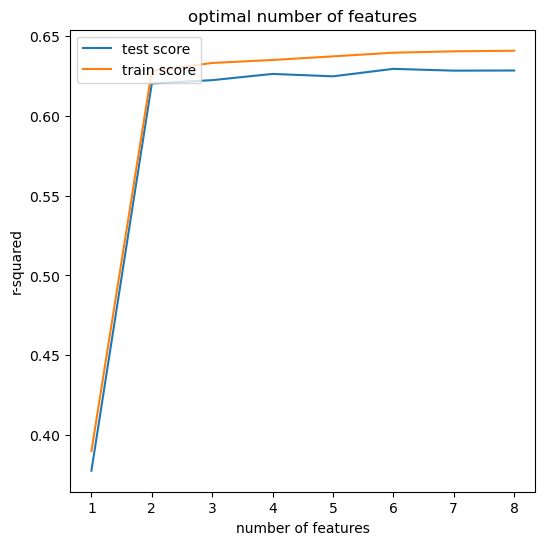

In [88]:
plt.figure(figsize=(6, 6));
plt.plot(result_CVGS['param_n_features_to_select'], result_CVGS['mean_test_score']);
plt.plot(result_CVGS['param_n_features_to_select'], result_CVGS['mean_train_score']);
plt.xlabel("number of features");
plt.ylabel("r-squared");
plt.title("optimal number of features");
plt.legend(["test score","train score"], loc= "upper left");

In [89]:
n_features_optimal = 6

In [90]:
lm_final = LinearRegression()

In [91]:
lm_final.fit(insurance_data_x_train, insurance_data_y_train)

LinearRegression()

In [92]:
rfe_final = RFE(lm_final,n_features_to_select = n_features_optimal)

In [93]:
rfe_final = rfe_final.fit(insurance_data_x_train, insurance_data_y_train)

Prediction and error metrics for test data

In [94]:
y_pred_test_final = lm_final.predict(insurance_data_x_test)

In [95]:
r2 = sklearn.metrics.r2_score(insurance_data_y_test, y_pred_test_final)

In [96]:
mae = sklearn.metrics.mean_absolute_error(insurance_data_y_test,y_pred_test_final)

In [97]:
mse = sklearn.metrics.mean_squared_error(insurance_data_y_test,y_pred_test_final,squared=True)

In [98]:
rmse = sklearn.metrics.mean_squared_error(insurance_data_y_test,y_pred_test_final, squared=False)

In [99]:
print(r2,mae,mse,rmse)

0.5281536017764867 0.08312395607602051 0.02392718810285349 0.15468415595287544


The model explains 52.8% of the variance in the target variable, which can be considered moderate performance. The average deviation of the predictions from the true values ​​is 0.083 units, indicating a low magnitude error. The magnitude of the error in both MSE and RMSE is significant on a unit basis.

#### Artificial Neural Networks

I have already made the preprocessing steps. Continuing from there.

Defining x and y

In [100]:
y = insurance_data["charges"]

In [102]:
x = insurance_data.loc[:, ["age", "sex", "bmi", "children", "smoker", "northwest", "southeast", "southwest"]]

Splitting as train and test

In [103]:
insurance_data_x_train, insurance_data_x_test, insurance_data_y_train, insurance_data_y_test = train_test_split(x,
                                                                                                                y,
                                                                                                                test_size=0.20,
                                                                                                                random_state=22)

In [104]:
insurance_data_y_train = np.array(insurance_data_y_train)

In [106]:
insurance_data_y_test = np.array(insurance_data_y_test)

Scaling the data

In [109]:
scalerANN = StandardScaler()

Scaling train and test sets

In [110]:
insurance_data_x_train_scaled = scalerANN.fit_transform(insurance_data_x_train)

In [111]:
insurance_data_x_test_scaled = scalerANN.transform(insurance_data_x_test)

In [112]:
insurance_data_y_train = insurance_data_y_train.reshape(-1, 1)

In [113]:
insurance_data_y_test = insurance_data_y_test.reshape(-1, 1)

Doing the same for our dependent variable

In [114]:
insurance_data_y_train_scaled = scalerANN.fit_transform(insurance_data_y_train)

In [115]:
insurance_data_y_test_scaled = scalerANN.transform(insurance_data_y_test)

Modelling

In [117]:
aNN = MLPRegressor(random_state=22).fit(insurance_data_x_train_scaled, insurance_data_y_train_scaled)

What should we use as random state?

In [118]:
aNN.random_state

22

Where does the loss come from?

In [120]:
aNN.loss

'squared_error'

the value of the loss

Number of hidden layers

In [123]:
aNN.hidden_layer_sizes

(100,)

How many layers?

In [125]:
aNN.n_features_in_

8

Let's find prediction and errors

Train set prediction

In [127]:
y_pred_aNN_Train = aNN.predict(insurance_data_x_train_scaled)

In [128]:
y_pred_aNN_Train

array([ 1.78368095e-01,  1.19160853e-02,  1.59253691e+00, -6.70806016e-01,
        1.19543346e-01,  2.92924806e-02,  5.20682527e-01, -3.19127570e-01,
       -1.96906765e-02, -8.69950575e-03,  7.12273437e-01, -1.74700865e-01,
       -4.52790455e-01, -7.32231450e-01,  2.69820363e-01,  2.91429364e-01,
        7.38326416e-01, -1.08176460e+00,  1.85087485e+00, -1.65580070e-01,
       -6.30074508e-01,  2.36240995e+00, -1.05149497e+00, -1.01490564e+00,
       -1.86544845e-01, -8.64930972e-01,  6.33253480e-01, -5.86256066e-01,
       -2.80863516e-01, -7.94283616e-01, -5.66180581e-01,  1.21830893e-02,
       -2.82530140e-02,  3.88918090e-01,  5.94596030e-01,  7.62494318e-01,
        4.82069578e-01, -3.12743343e-01, -5.19226989e-01, -4.72378747e-03,
        3.60187642e-01,  8.63465604e-01,  1.33312676e+00, -1.60632548e-01,
       -5.36197381e-01, -7.26677810e-01, -8.67388272e-01, -9.92732576e-01,
       -2.26397155e-01, -1.07672962e-01, -8.82068066e-01, -1.00108799e+00,
        2.25765815e+00,  

Test set prediction

In [129]:
y_pred_aNN_Test = aNN.predict(insurance_data_x_test_scaled)

In [130]:
y_pred_aNN_Test

array([-0.81728759, -0.85936462, -0.40151251,  0.03587837,  0.27090131,
        0.08859109, -0.52016754, -0.05828711,  0.60700774, -1.00579668,
        0.04833318, -1.01912207,  0.27265124, -0.552328  ,  0.28809448,
        0.92685722, -1.04067781, -0.96057813, -0.65581747,  0.51303252,
       -0.63692156, -0.57321804,  0.39705875, -0.54311981, -0.65219093,
        0.14895535,  0.72265936, -0.59092256, -0.33159159, -0.23487725,
        0.56793969,  0.20099509,  0.37700584, -1.15187653, -0.40796966,
        0.51083109, -0.60011636, -0.29640345,  1.99075531, -0.34416477,
       -0.09187743, -0.5982048 ,  0.48766678, -0.38302532,  1.87215189,
       -0.61164728,  2.12383868,  0.58734645, -0.59790208, -0.22227478,
        0.51637992,  2.04568421,  0.82590559,  0.4729261 , -0.74034303,
       -0.06489073, -0.58403016,  1.62523476, -0.80997415, -0.60079466,
       -0.46233633,  2.55595562, -0.5134369 , -0.47921443, -0.4856353 ,
       -0.78260925,  0.19787723, -1.10423898,  0.09558568, -0.05

Finding real value with transformation

In [131]:
truepredict_ann_train = y_pred_aNN_Train * np.std(y_pred_aNN_Train) + np.mean(y_pred_aNN_Train)

In [132]:
truepredict_ann_train

array([ 1.49515960e-01,  1.25707091e-02,  1.31299668e+00, -5.49126021e-01,
        1.01119007e-01,  2.68668106e-02,  4.31148702e-01, -2.59789214e-01,
       -1.34331579e-02, -4.39037951e-03,  5.88776509e-01, -1.40964867e-01,
       -3.69757831e-01, -5.99662638e-01,  2.24756589e-01,  2.42534987e-01,
        6.10211106e-01, -8.87234443e-01,  1.52553935e+00, -1.33460905e-01,
       -5.15614941e-01,  1.94639520e+00, -8.62330679e-01, -8.32227493e-01,
       -1.50709278e-01, -7.08838667e-01,  5.23764330e-01, -4.79564144e-01,
       -2.28308185e-01, -6.50714887e-01, -4.63047418e-01,  1.27903816e-02,
       -2.04776596e-02,  3.22741997e-01,  4.91959642e-01,  6.30094792e-01,
        3.99380627e-01, -2.54536711e-01, -4.24417236e-01, -1.11943230e-03,
        2.99104563e-01,  7.13167012e-01,  1.09957187e+00, -1.29390424e-01,
       -4.38379306e-01, -5.95093486e-01, -7.10860364e-01, -8.13985026e-01,
       -1.83497014e-01, -8.58189236e-02, -7.22937887e-01, -8.20859282e-01,
        1.86021263e+00,  

In [133]:
truepredict_ann_test = y_pred_aNN_Test * np.std(y_pred_aNN_Test) + np.mean(y_pred_aNN_Test)

In [134]:
truepredict_ann_test

array([-6.73303610e-01, -7.08493152e-01, -3.25585734e-01,  4.02097000e-02,
        2.36762305e-01,  8.42939972e-02, -4.24818413e-01, -3.85420668e-02,
        5.17852296e-01, -8.30956102e-01,  5.06258067e-02, -8.42100295e-01,
        2.38225793e-01, -4.51714609e-01,  2.51141163e-01,  7.85346393e-01,
       -8.60127623e-01, -7.93139271e-01, -5.38264137e-01,  4.39259644e-01,
       -5.22461252e-01, -4.69185208e-01,  3.42269337e-01, -4.44013680e-01,
       -5.35231219e-01,  1.34777380e-01,  6.14573176e-01, -4.83991721e-01,
       -2.67110000e-01, -1.86226600e-01,  4.85179192e-01,  1.78298862e-01,
        3.25498844e-01, -9.53124503e-01, -3.30985932e-01,  4.37418564e-01,
       -4.91680603e-01, -2.37681725e-01,  1.67509760e+00, -2.77625106e-01,
       -6.66340642e-02, -4.90081950e-01,  4.18045964e-01, -3.10124673e-01,
        1.57590808e+00, -5.01324062e-01,  1.78639687e+00,  5.01409307e-01,
       -4.89828779e-01, -1.75686992e-01,  4.42059117e-01,  1.72103532e+00,
        7.00919289e-01,  

Train set error

In [136]:
RMSE_aNN_train = np.sqrt(mean_squared_error(insurance_data_y_train_scaled, truepredict_ann_train))

In [137]:
R2_aNN_train = r2_score(insurance_data_y_train_scaled, truepredict_ann_train)

In [138]:
print(RMSE_aNN_train, R2_aNN_train)

0.5654719060706401 0.6802415234448371


The model explains 68.02% of the variance in the target variable. This is a moderate-to-good performance for the r squared variable.

Test set error

In [140]:
RMSE_aNN_test = np.sqrt(mean_squared_error(insurance_data_y_test_scaled, truepredict_ann_test))

In [141]:
R2_aNN_test = r2_score(insurance_data_y_test_scaled, truepredict_ann_test)

In [142]:
print(RMSE_aNN_test, R2_aNN_test)

0.6882834394945068 0.5629878009067582


Model's train set scores are better. There might be overfitting.

#### GridSearch Optimization

In [144]:
aNN_params = {'alpha': [0.1, 0.01, 0.02, 0.001, 0.0001],
              'hidden_layer_sizes': [(10,20), (5,5), (100,100)]}

In [145]:
aNNfCV = MLPRegressor(random_state=22)

In [146]:
aNN_CVGS = GridSearchCV(aNNfCV, aNN_params,
                        cv = 5,
                        n_jobs = -1,
                        verbose = 2).fit(insurance_data_x_train_scaled, insurance_data_y_train_scaled)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/serminazizoglu/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/serminazizoglu/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/serminazizoglu/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/serminazizoglu/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_

In [147]:
aNN_CVGS.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': (5, 5)}

Using the best hyperparameters

In [148]:
aNN_Best = MLPRegressor(alpha=0.1,
                        hidden_layer_sizes = (100,100),
                        random_state= 22).fit(insurance_data_x_train_scaled, insurance_data_y_train_scaled)

Train set prediction

In [157]:
y_pred_aNN_Best_train = aNN_Best.predict(insurance_data_x_train_scaled)

In [158]:
y_pred_aNN_Best_train

array([ 7.26387759e-02, -1.74257170e-01,  1.63448987e+00, -6.45367815e-01,
        1.14374659e-01,  1.15130626e-01,  4.85270532e-01, -4.22533746e-01,
       -8.82063515e-02, -3.07798817e-02,  7.92988328e-01, -2.69092083e-01,
       -5.21033591e-01, -4.90773967e-01, -4.39702799e-03,  3.42532861e-01,
        6.53538190e-01, -1.18918775e+00,  1.62829772e+00, -2.67333601e-01,
       -8.35528612e-01,  2.35545978e+00, -1.10636136e+00, -9.93518293e-01,
       -7.48557586e-02, -8.62462674e-01,  6.85227221e-01, -8.60163857e-01,
       -3.28716923e-01, -9.22082007e-01, -5.50944349e-01, -8.35635577e-02,
       -8.63844955e-02,  3.41761581e-01,  1.20516227e+00,  6.39482483e-01,
        5.50062532e-01, -4.38460035e-01, -6.40873173e-01, -3.13339371e-02,
        5.09686016e-01,  8.98344259e-01,  1.47424551e+00, -7.99365112e-02,
       -6.91927347e-01, -6.65779590e-01, -9.21195642e-01, -1.02833312e+00,
       -4.02527009e-01, -1.26102943e-01, -9.61675240e-01, -1.01127259e+00,
        2.97361074e+00,  

Test set prediction

In [151]:
y_pred_aNN_Best_test = aNN_Best.predict(insurance_data_x_test_scaled)

In [152]:
y_pred_aNN_Best_test

array([-1.10861262e+00, -8.74408466e-01, -4.73797791e-01,  9.34273089e-01,
        6.99572044e-01,  1.03233379e-01, -4.80550578e-01, -1.13391222e-02,
        5.88900394e-01, -1.10024661e+00, -1.09073889e-01, -1.12046091e+00,
        2.73640247e-01, -5.31918142e-01,  3.33820054e-01,  6.88450631e-01,
       -1.15193301e+00, -4.60706485e-01, -5.91320964e-01,  6.42701008e-01,
       -6.98954756e-01, -6.30680364e-01,  3.92370913e-01, -6.76558939e-01,
       -6.06870176e-01,  1.75471480e-01,  8.03113045e-01, -4.95141989e-01,
       -2.88171763e-01, -9.51275150e-02,  7.77668259e-01,  1.38850466e-01,
        2.15750413e-01, -1.11679882e+00, -4.90963436e-01,  5.85823128e-01,
       -8.41396320e-01, -3.84582779e-01,  2.01358339e+00, -2.15924794e-01,
       -1.03574046e-01, -6.92340576e-01,  4.65551897e-01, -5.92935259e-01,
        2.15462763e+00, -6.21428390e-01,  2.02133269e+00,  5.10496013e-01,
       -7.17032582e-01, -3.07619018e-01,  3.95560072e-01,  2.00815631e+00,
        8.71829843e-01,  

In [161]:
truepredict_ann_best_train = y_pred_aNN_Best_train * np.std(y_pred_aNN_Best_train) + np.mean(y_pred_aNN_Best_train)

In [163]:
truepredict_ann_best_train

array([ 6.30350555e-02, -1.49931018e-01,  1.41024751e+00, -5.56298906e-01,
        9.90353514e-02,  9.96874295e-02,  4.18960562e-01, -3.64087987e-01,
       -7.57058017e-02, -2.61712104e-02,  6.84389994e-01, -2.31733167e-01,
       -4.49051411e-01, -4.22950240e-01, -3.41404145e-03,  2.95838730e-01,
        5.64103903e-01, -1.02538395e+00,  1.40490633e+00, -2.30216345e-01,
       -7.20326703e-01,  2.03213756e+00, -9.53940047e-01, -8.56604525e-01,
       -6.41899247e-02, -7.43559330e-01,  5.91438044e-01, -7.41576430e-01,
       -2.83164016e-01, -7.94985428e-01, -4.74851660e-01, -7.17010475e-02,
       -7.41343156e-02,  2.95173444e-01,  1.03992061e+00,  5.51979813e-01,
        4.74848470e-01, -3.77825593e-01, -5.52421943e-01, -2.66491243e-02,
        4.40020729e-01,  7.75267303e-01,  1.27202486e+00, -6.85724508e-02,
       -5.96459956e-01, -5.73905576e-01, -7.94220872e-01, -8.86634895e-01,
       -3.46830692e-01, -1.08394424e-01, -8.29137529e-01, -8.71918924e-01,
        2.56533863e+00,  

[CV] END .............alpha=0.1, hidden_layer_sizes=(10, 20); total time=   0.2s
[CV] END ...............alpha=0.1, hidden_layer_sizes=(5, 5); total time=   0.1s
[CV] END ...........alpha=0.1, hidden_layer_sizes=(100, 100); total time=   0.8s
[CV] END ............alpha=0.02, hidden_layer_sizes=(10, 20); total time=   0.2s
[CV] END ............alpha=0.02, hidden_layer_sizes=(10, 20); total time=   0.1s
[CV] END ..............alpha=0.02, hidden_layer_sizes=(5, 5); total time=   0.1s
[CV] END ..........alpha=0.02, hidden_layer_sizes=(100, 100); total time=   0.7s
[CV] END .........alpha=0.001, hidden_layer_sizes=(100, 100); total time=   0.7s
[CV] END ...............alpha=0.1, hidden_layer_sizes=(5, 5); total time=   0.1s
[CV] END ...........alpha=0.1, hidden_layer_sizes=(100, 100); total time=   0.8s
[CV] END ............alpha=0.02, hidden_layer_sizes=(10, 20); total time=   0.2s
[CV] END ..............alpha=0.02, hidden_layer_sizes=(5, 5); total time=   0.1s
[CV] END ..............alpha

In [164]:
truepredict_ann_best_test = y_pred_aNN_Best_test * np.std(y_pred_aNN_Best_test) + np.mean(y_pred_aNN_Best_test)

In [165]:
truepredict_ann_best_test

array([-9.68784044e-01, -7.62467336e-01, -4.09558672e-01,  8.30848650e-01,
        6.24094218e-01,  9.87635286e-02, -4.15507382e-01, -2.16645352e-03,
        5.26600600e-01, -9.61414203e-01, -8.82636255e-02, -9.79221518e-01,
        2.48879500e-01, -4.60758444e-01,  3.01893502e-01,  6.14297068e-01,
       -1.00694614e+00, -3.98026190e-01, -5.13087980e-01,  5.73995001e-01,
       -6.07905468e-01, -5.47760728e-01,  3.53472521e-01, -5.88176393e-01,
       -5.26785696e-01,  1.62400005e-01,  7.15306257e-01, -4.28361346e-01,
       -2.46035735e-01, -7.59778911e-02,  6.92891264e-01,  1.30139574e-01,
        1.97882795e-01, -9.75995488e-01, -4.24680347e-01,  5.23889754e-01,
       -7.33386053e-01, -3.30966779e-01,  1.78164198e+00, -1.82391447e-01,
       -8.34186663e-02, -6.02078859e-01,  4.17939608e-01, -5.14510055e-01,
        1.90589162e+00, -5.39610417e-01,  1.78846854e+00,  4.57532083e-01,
       -6.23830708e-01, -2.63167343e-01,  3.56281936e-01,  1.77686112e+00,
        7.75840723e-01,  

Calculating metrics for true predictions

for trainset

In [166]:
RMSE_aNN_Best_train = np.sqrt(mean_squared_error(insurance_data_y_train_scaled, truepredict_ann_best_train))

In [167]:
r2_aNN_Best_train = r2_score(insurance_data_y_train_scaled, truepredict_ann_best_train)

In [168]:
print(RMSE_aNN_Best_train, r2_aNN_Best_train)

0.4736827937778264 0.7756246108788332


for testset

In [172]:
RMSE_aNN_Best_test = np.sqrt(mean_squared_error(insurance_data_y_test_scaled, truepredict_ann_best_test))

In [173]:
r2_aNN_Best_test = r2_score(insurance_data_y_test_scaled, truepredict_ann_best_test)

In [174]:
print(RMSE_aNN_Best_test, r2_aNN_Best_test)

0.7167265235929147 0.5261227354770746


Trainset performance is better again. There might be overfitting

#### K NEAREST NEIGHBOR

Modelling

In [176]:
kNN = KNeighborsRegressor().fit(insurance_data_x_train, insurance_data_y_train)

In [177]:
y_pred_knn_train = kNN.predict(insurance_data_x_train)

In [178]:
y_pred_knn_train

array([[17107.42875  ],
       [ 7516.407    ],
       [11199.74621  ],
       [ 4754.56197  ],
       [ 9133.78959  ],
       [ 8765.78461  ],
       [13757.6447   ],
       [ 6937.23557  ],
       [ 6967.12842  ],
       [12653.081482 ],
       [13356.11875  ],
       [13577.75478  ],
       [ 6712.50602  ],
       [ 3323.81345  ],
       [16253.46022  ],
       [13020.537364 ],
       [14452.05923  ],
       [ 2204.14686  ],
       [10240.47797  ],
       [10964.09939  ],
       [ 6425.584438 ],
       [22567.498004 ],
       [ 2818.86774  ],
       [ 5452.88391  ],
       [13316.064218 ],
       [ 4134.32373  ],
       [15491.36003  ],
       [ 3786.1243   ],
       [ 9883.37703  ],
       [ 2275.74966  ],
       [10398.434328 ],
       [ 7963.811068 ],
       [ 8488.25874  ],
       [12990.184998 ],
       [13380.767766 ],
       [13965.00411  ],
       [12088.052916 ],
       [ 8056.80698  ],
       [ 9702.2102   ],
       [ 9132.949    ],
       [15971.671512 ],
       [ 9268.96

In [179]:
y_pred_knn_test = kNN.predict(insurance_data_x_test)

In [180]:
y_pred_knn_test

array([[ 1937.61177  ],
       [ 4197.102136 ],
       [ 6246.54266  ],
       [11669.137356 ],
       [ 6700.064634 ],
       [12848.488894 ],
       [12794.86453  ],
       [10374.05771  ],
       [18890.094222 ],
       [ 2148.01638  ],
       [12270.14443  ],
       [ 8250.02661  ],
       [13767.78956  ],
       [ 5490.526714 ],
       [10116.56151  ],
       [ 9248.59805  ],
       [ 2210.38923  ],
       [ 1912.09985  ],
       [ 8126.27812  ],
       [13919.83562  ],
       [ 5125.01276  ],
       [ 8098.68164  ],
       [12990.184998 ],
       [ 7572.28929  ],
       [ 8263.02625  ],
       [ 8853.7435   ],
       [22849.04962  ],
       [10336.797548 ],
       [14536.14478  ],
       [12694.78525  ],
       [12044.83618  ],
       [13073.651644 ],
       [ 2180.84065  ],
       [ 6594.13848  ],
       [ 9176.38072  ],
       [12842.17174  ],
       [ 5684.900696 ],
       [ 6631.04803  ],
       [13480.09491  ],
       [ 6656.24579  ],
       [11093.040592 ],
       [ 4066.15

Since the KNN model is trained on the original train and test set, the predictions are true predictions.

Let's find model metrics.

For train set

In [182]:
RMSE_knn_train = np.sqrt(mean_squared_error(insurance_data_y_train, y_pred_knn_train))

In [183]:
r2_knn_train = r2_score(insurance_data_y_train, y_pred_knn_train)

In [184]:
print(RMSE_knn_train, r2_knn_train)

5148.569954156119 0.4854738951715074


for test set

In [185]:
RMSE_knn_test = np.sqrt(mean_squared_error(insurance_data_y_test, y_pred_knn_test))

In [186]:
r2_knn_test = r2_score(insurance_data_y_test, y_pred_knn_test)

In [187]:
print(RMSE_knn_test, r2_knn_test)

6746.453275823446 0.18502529089641173


test set errors are bigger

In [189]:
kNN_params = {'n_neighbors': np.arange(1, 30, 1)}

In [190]:
kNN = KNeighborsRegressor()

In [191]:
kNN_CVGS = GridSearchCV(kNN, kNN_params, cv = 10).fit(insurance_data_x_train, insurance_data_y_train)

The parameter of the best among alternative models

In [192]:
kNN_CVGS.best_params_

{'n_neighbors': 29}

Modelling with the best parameter

In [194]:
kNN_Tuned_CVGS = KNeighborsRegressor(n_neighbors= kNN_CVGS.best_params_['n_neighbors']).fit(insurance_data_x_train, insurance_data_y_train)

train set predictions

In [196]:
y_pred_knn_tuned_CVGS_train = kNN_Tuned_CVGS.predict(insurance_data_x_train)

test set predictions

In [198]:
y_pred_knn_tuned_CVGS_test = kNN_Tuned_CVGS.predict(insurance_data_x_test)

Metrics of the model over the train set for true predictions

In [200]:
RMSE_knn_tuned_CVGS_train = np.sqrt(mean_squared_error(insurance_data_y_train, y_pred_knn_tuned_CVGS_train))

In [201]:
R2_knn_tuned_CVGS_train = r2_score(insurance_data_y_train, y_pred_knn_tuned_CVGS_train)

In [202]:
print(RMSE_knn_tuned_CVGS_train, R2_knn_tuned_CVGS_train)

6019.926697664467 0.29657696810496936


for test set

In [203]:
RMSE_knn_tuned_CVGS_test = np.sqrt(mean_squared_error(insurance_data_y_test, y_pred_knn_tuned_CVGS_test))

In [204]:
R2_knn_tuned_CVGS_test = r2_score(insurance_data_y_test, y_pred_knn_tuned_CVGS_test)

In [205]:
print(RMSE_knn_tuned_CVGS_test, R2_knn_tuned_CVGS_test)

6641.181233583838 0.2102606792929319


Train and test set performance are pretty low.

For conclusion we can say that the ANN model is more successful.